In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
df = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\Cartera Nivelacion formateada.xlsx', sheet_name = 'Hoja2')

In [63]:
df

,ESTACION,PV,DATO V+,V-,Cota
0,MACARENA B,NaN,1.3294,1.3323,2710.4
1,NaN,C1,1.7418,0.6506,NaN
2,NaN,C3,1.6906,0.8582,NaN
3,NaN,C4,1.8013,0.6549,NaN
4,NaN,C5,2.5017,3.0777,NaN
5,NaN,C6,1.6002,3.0491,NaN
6,NaN,C7,1.5995,3.7519,NaN
7,NaN,C8,1.5766,3.2225,NaN
8,NaN,C9,2.5648,3.8358,NaN
9,NaN,C10,0.8417,1.6871,NaN


In [64]:
# Utilizamos esta formula para realizar la operacion columna por columna
df['resta'] = df['DATO V+'] - df['V-']

df['Sube'] = np.where(df['resta'] > 0, df['resta'], np.nan)
df['Baja'] = np.where(df['resta'] < 0, abs(df['resta']), np.nan)

In [65]:
df

,ESTACION,PV,DATO V+,V-,Cota,resta,Sube,Baja
0,MACARENA B,NaN,1.3294,1.3323,2710.4,-0.0029,NaN,0.0029
1,NaN,C1,1.7418,0.6506,NaN,1.0912,1.0912,NaN
2,NaN,C3,1.6906,0.8582,NaN,0.8324,0.8324,NaN
3,NaN,C4,1.8013,0.6549,NaN,1.1464,1.1464,NaN
4,NaN,C5,2.5017,3.0777,NaN,-0.5760,NaN,0.5760
5,NaN,C6,1.6002,3.0491,NaN,-1.4489,NaN,1.4489
6,NaN,C7,1.5995,3.7519,NaN,-2.1524,NaN,2.1524
7,NaN,C8,1.5766,3.2225,NaN,-1.6459,NaN,1.6459
8,NaN,C9,2.5648,3.8358,NaN,-1.2710,NaN,1.2710
9,NaN,C10,0.8417,1.6871,NaN,-0.8454,NaN,0.8454


In [66]:
# Crear columnas desplazadas para "Sube" y "Baja", corriendo una fila hacia abajo
df['Sube_shifted'] = df['Sube'].shift(1)
df['Baja_shifted'] = df['Baja'].shift(1)

# Mantenemos intacto el primer valor de cota para no desorganizar los datos dados
# Este es un bucle que inicia desde la fila 1 (No inicia desde la fila 0 puesto que corrimos una fila hacia abajo para no modificar el valor de cota)
for i in range(1, len(df)):
    # Esta linea lo que hace es verificar si el valor NO es un Nan, en caso de que no lo sea especificamente en la posicion
    # i de la columna sube_shifted lo que hacemos es que en la posicion i de cota se sume el valor de la fila de arriba de cota con 
    # Sube shifted dependiendo si es o no un sube o un baja
    if not pd.isna(df.loc[i, 'Sube_shifted']):
        df.loc[i, 'Cota'] = df.loc[i-1, 'Cota'] + df.loc[i, 'Sube_shifted']
    elif not pd.isna(df.loc[i, 'Baja_shifted']):
        df.loc[i, 'Cota'] = df.loc[i-1, 'Cota'] - df.loc[i, 'Baja_shifted']

In [67]:
df

,ESTACION,PV,DATO V+,V-,Cota,resta,Sube,Baja,Sube_shifted,Baja_shifted
0,MACARENA B,NaN,1.3294,1.3323,2710.4000,-0.0029,NaN,0.0029,NaN,NaN
1,NaN,C1,1.7418,0.6506,2710.3971,1.0912,1.0912,NaN,NaN,0.0029
2,NaN,C3,1.6906,0.8582,2711.4883,0.8324,0.8324,NaN,1.0912,NaN
3,NaN,C4,1.8013,0.6549,2712.3207,1.1464,1.1464,NaN,0.8324,NaN
4,NaN,C5,2.5017,3.0777,2713.4671,-0.5760,NaN,0.5760,1.1464,NaN
5,NaN,C6,1.6002,3.0491,2712.8911,-1.4489,NaN,1.4489,NaN,0.5760
6,NaN,C7,1.5995,3.7519,2711.4422,-2.1524,NaN,2.1524,NaN,1.4489
7,NaN,C8,1.5766,3.2225,2709.2898,-1.6459,NaN,1.6459,NaN,2.1524
8,NaN,C9,2.5648,3.8358,2707.6439,-1.2710,NaN,1.2710,NaN,1.6459
9,NaN,C10,0.8417,1.6871,2706.3729,-0.8454,NaN,0.8454,NaN,1.2710


In [68]:
# Eliminar las columnas auxiliares para que no sean visibles
df = df.drop(columns=['Sube_shifted', 'Baja_shifted', 'resta'])

In [69]:
df

,ESTACION,PV,DATO V+,V-,Cota,Sube,Baja
0,MACARENA B,NaN,1.3294,1.3323,2710.4000,NaN,0.0029
1,NaN,C1,1.7418,0.6506,2710.3971,1.0912,NaN
2,NaN,C3,1.6906,0.8582,2711.4883,0.8324,NaN
3,NaN,C4,1.8013,0.6549,2712.3207,1.1464,NaN
4,NaN,C5,2.5017,3.0777,2713.4671,NaN,0.5760
5,NaN,C6,1.6002,3.0491,2712.8911,NaN,1.4489
6,NaN,C7,1.5995,3.7519,2711.4422,NaN,2.1524
7,NaN,C8,1.5766,3.2225,2709.2898,NaN,1.6459
8,NaN,C9,2.5648,3.8358,2707.6439,NaN,1.2710
9,NaN,C10,0.8417,1.6871,2706.3729,NaN,0.8454


In [70]:
# Ahora calculamos la altura instrumental a partir de la primera hoja para comparar los resultados
df2 = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\Cartera Nivelacion formateada.xlsx')

In [71]:
df2

,ESTACION,PV,DATO V+,V-,ALTURA INSTRUMENTAL,COTA
0,MACARENA B,NaN,1.3294,1.3323,NaN,2710.4
1,NaN,C1,1.7418,0.6506,NaN,NaN
2,NaN,C3,1.6906,0.8582,NaN,NaN
3,NaN,C4,1.8013,0.6549,NaN,NaN
4,NaN,C5,2.5017,3.0777,NaN,NaN
5,NaN,C6,1.6002,3.0491,NaN,NaN
6,NaN,C7,1.5995,3.7519,NaN,NaN
7,NaN,C8,1.5766,3.2225,NaN,NaN
8,NaN,C9,2.5648,3.8358,NaN,NaN
9,NaN,C10,0.8417,1.6871,NaN,NaN


In [72]:
# Bucle while para calcular ALTURA INSTRUMENTAL y COTA hasta que no haya cambios
cambios_realizados = True

while cambios_realizados:
    cambios_realizados = False  # Asumir que no se harán más cambios en esta iteración
    for i in range(len(df2)):
        if i == 0:
            # Para la primera fila, calcular ALTURA INSTRUMENTAL con COTA y DATO V+
            df2.loc[i, 'ALTURA INSTRUMENTAL'] = df2.loc[i, 'COTA'] + df2.loc[i, 'DATO V+']
            continue

        # Obtener COTA anterior
        cota_anterior = df2.loc[i - 1, 'COTA']

        # Calcular ALTURA INSTRUMENTAL usando la COTA actual
        altura_instrumental_anterior = df2.loc[i - 1, 'ALTURA INSTRUMENTAL']
        df2.loc[i, 'ALTURA INSTRUMENTAL'] = df2.loc[i, 'DATO V+'] + df2.loc[i, 'COTA']

        # Calcular COTA
        v_minus = df2.loc[i - 1, 'V-'] if pd.notna(df2.loc[i - 1, 'V-']) else 0  # Manejar valores nulos
        nueva_cota = altura_instrumental_anterior - v_minus

        # Verificar si hay cambios en COTA
        if df2.loc[i, 'COTA'] != nueva_cota:
            df2.loc[i, 'COTA'] = nueva_cota
            cambios_realizados = True  # Se ha realizado un cambio

In [73]:
df2

,ESTACION,PV,DATO V+,V-,ALTURA INSTRUMENTAL,COTA
0,MACARENA B,NaN,1.3294,1.3323,2711.7294,2710.4000
1,NaN,C1,1.7418,0.6506,2712.1389,2710.3971
2,NaN,C3,1.6906,0.8582,2713.1789,2711.4883
3,NaN,C4,1.8013,0.6549,2714.1220,2712.3207
4,NaN,C5,2.5017,3.0777,2715.9688,2713.4671
5,NaN,C6,1.6002,3.0491,2714.4913,2712.8911
6,NaN,C7,1.5995,3.7519,2713.0417,2711.4422
7,NaN,C8,1.5766,3.2225,2710.8664,2709.2898
8,NaN,C9,2.5648,3.8358,2710.2087,2707.6439
9,NaN,C10,0.8417,1.6871,2707.2146,2706.3729


Como podemos evidenciar ambas cotas dan el mismo resultado por ende el codigo funciona correctamente

In [74]:
# Mostrar Las vistas intermedias, osea los valores de bajas
vistas_intermedias = df[['PV', 'Baja']].dropna().reset_index(drop=True)
print(vistas_intermedias)


     PV    Baja
0    C5  0.5760
1    C6  1.4489
2    C7  2.1524
3    C8  1.6459
4    C9  1.2710
5   C10  0.8454
6   C11  0.4851
7   C12  1.4834
8   C13  0.0865
9   C14  0.3898
10  C15  0.1425
11  C16  0.2149
12  C17  1.1140
13  C18  1.4789
14  C19  0.7115
15  C34  0.1262
16  C35  0.0146
17  C37  0.7912
18  C38  1.9307
19  C39  2.0800
20  C40  1.9201
21  C41  1.8095
22  C42  0.9831


In [75]:
df

,ESTACION,PV,DATO V+,V-,Cota,Sube,Baja
0,MACARENA B,NaN,1.3294,1.3323,2710.4000,NaN,0.0029
1,NaN,C1,1.7418,0.6506,2710.3971,1.0912,NaN
2,NaN,C3,1.6906,0.8582,2711.4883,0.8324,NaN
3,NaN,C4,1.8013,0.6549,2712.3207,1.1464,NaN
4,NaN,C5,2.5017,3.0777,2713.4671,NaN,0.5760
5,NaN,C6,1.6002,3.0491,2712.8911,NaN,1.4489
6,NaN,C7,1.5995,3.7519,2711.4422,NaN,2.1524
7,NaN,C8,1.5766,3.2225,2709.2898,NaN,1.6459
8,NaN,C9,2.5648,3.8358,2707.6439,NaN,1.2710
9,NaN,C10,0.8417,1.6871,2706.3729,NaN,0.8454


In [81]:
df3 = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\NivelacionEjemploCartagenitaFormateada.xlsx', sheet_name = 'Perfil')

In [82]:
df3

,Estación,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,Cota,Elipsoidal
0,Cart,7.51,4.53,NaN,100.0,2581.1255,2611.1255
1,C1,7.85,6.98,NaN,NaN,2582.1254,2604.6254
2,C2,8.15,3.25,NaN,NaN,2583.9647,2611.3147
3,C3,7.85,7.01,NaN,NaN,2585.8546,2610.1246
4,C4,7.45,7.35,NaN,NaN,2588.0483,2619.8283
5,C5,NaN,NaN,NaN,NaN,2590.0753,2611.2653


In [83]:
df3['Distancia entre cambios'] = df3['Distancia1'] + df3['Distancia2']

In [84]:
df3

,Estación,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,Cota,Elipsoidal
0,Cart,7.51,4.53,12.04,100.0,2581.1255,2611.1255
1,C1,7.85,6.98,14.83,NaN,2582.1254,2604.6254
2,C2,8.15,3.25,11.40,NaN,2583.9647,2611.3147
3,C3,7.85,7.01,14.86,NaN,2585.8546,2610.1246
4,C4,7.45,7.35,14.80,NaN,2588.0483,2619.8283
5,C5,NaN,NaN,NaN,NaN,2590.0753,2611.2653


In [85]:
for i in range(len(df3)):
    if i > 0:
        df3.loc[i, 'Distancia Absoluta'] = df3.loc[i - 1, 'Distancia Absoluta'] + df3.loc[i-1, 'Distancia entre cambios']

In [86]:
df3

,Estación,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,Cota,Elipsoidal
0,Cart,7.51,4.53,12.04,100.00,2581.1255,2611.1255
1,C1,7.85,6.98,14.83,112.04,2582.1254,2604.6254
2,C2,8.15,3.25,11.40,126.87,2583.9647,2611.3147
3,C3,7.85,7.01,14.86,138.27,2585.8546,2610.1246
4,C4,7.45,7.35,14.80,153.13,2588.0483,2619.8283
5,C5,NaN,NaN,NaN,167.93,2590.0753,2611.2653


In [88]:
df4 = pd.read_excel(r'D:\Users\Jan Sanchez\Documents\Repositorios\Programacion\Tarea heidy\Punto_2\NivelacionEjemploCartagenitaFormateada.xlsx')
df4

,Estación,Punto Visado,V+,V-,Distancia1,Distancia2,Cota hi,Cota
0,Cart,C1,2.1517,NaN,7.51,4.53,2583.2772,2581.1255
1,C1,C2,2.7519,1.1518,7.85,6.98,2584.8773,2582.1254
2,C2,C3,3.0116,0.9126,8.15,3.25,2586.9763,2583.9647
3,C3,C4,3.1723,1.1217,7.85,7.01,2589.0269,2585.8546
4,C4,C5,3.2789,0.9786,7.45,7.35,2591.3272,2588.0483
5,C5,NaN,NaN,1.2519,NaN,NaN,NaN,2590.0753


In [94]:
# Asegúrate de que la columna 'Altura instrumental' existe en df3
df3['Altura instrumental'] = df4['Cota hi']

# Eliminar la columna 'Altura instrumental' y guardarla
altura_instrumental = df3.pop('Altura instrumental')

# Insertar la columna en la posición 6
df3.insert(5, 'Altura instrumental', altura_instrumental)


In [95]:
df3

,Estación,Distancia1,Distancia2,Distancia entre cambios,Distancia Absoluta,Altura instrumental,Cota,Elipsoidal
0,Cart,7.51,4.53,12.04,100.00,2583.2772,2581.1255,2611.1255
1,C1,7.85,6.98,14.83,112.04,2584.8773,2582.1254,2604.6254
2,C2,8.15,3.25,11.40,126.87,2586.9763,2583.9647,2611.3147
3,C3,7.85,7.01,14.86,138.27,2589.0269,2585.8546,2610.1246
4,C4,7.45,7.35,14.80,153.13,2591.3272,2588.0483,2619.8283
5,C5,NaN,NaN,NaN,167.93,NaN,2590.0753,2611.2653


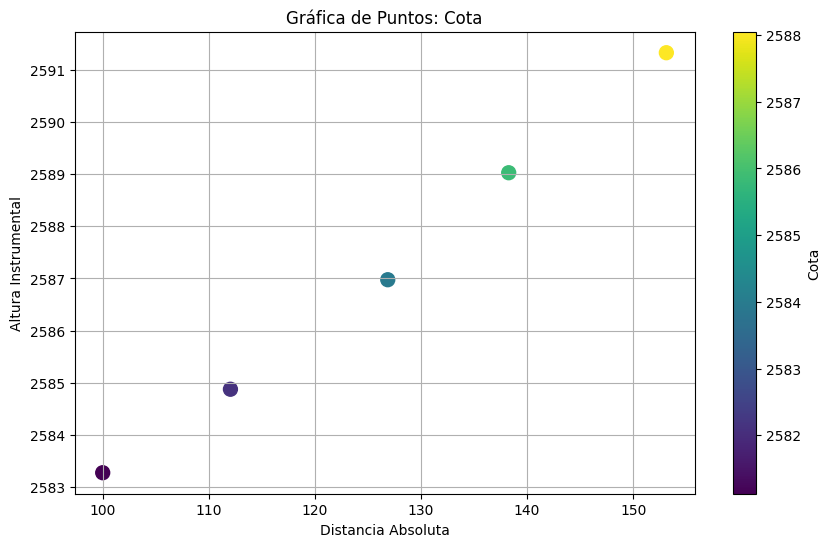

In [98]:
# Creamos la grafica
plt.figure(figsize=(10, 6))

# Graficar los puntos usando color en función de la columna Cota
scatter = plt.scatter(df3['distancia_absoluta'], df3['altura_instrumental'], 
                      c=df3['Cota'], cmap='viridis', s=100, marker='o')

# Mostrar los valores de Cota en cada punto
for i in range(len(df3)):
    plt.text(df3['distancia_absoluta'][i], df3['altura_instrumental'][i], 
             f'{df3["Cota"][i]:.2f}', fontsize=9, ha='right', va='bottom')

# Agregar barra de colores para visualizar los valores de Cota
plt.colorbar(scatter, label='Cota')

# Agregar títulos y etiquetas
plt.title('Gráfica de Puntos: Distancia Absoluta vs Altura Instrumental')
plt.xlabel('Distancia Absoluta')
plt.ylabel('Altura Instrumental')

# Ajustar la cuadrícula para que sea más detallada
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.minorticks_on()  # Activar las marcas menores de los ejes
plt.tick_params(axis='both', which='both', length=5)  # Ajustar tamaño de las marcas

# Mostrar la gráfica
plt.show()